In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import Adam
from tqdm import tqdm


In [ ]:
# Path to your dataset
data_dir = '/content/drive/MyDrive/deepsea 19'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split into training and validation sets (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Load the ViT model with the number of classes in your dataset
num_classes = len(dataset.classes)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=num_classes,ignore_mismatched_sizes=True )

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([19]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([19, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
optimizer = Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
def train_model(model, train_loader, val_loader, epochs=4):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(pixel_values=images).logits
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, train_loader, val_loader)


100%|██████████| 238/238 [04:37<00:00,  1.17s/it]


Epoch [1/4], Loss: 0.0079
Validation Accuracy: 99.95%


100%|██████████| 238/238 [04:37<00:00,  1.17s/it]


Epoch [2/4], Loss: 0.0047
Validation Accuracy: 99.95%


100%|██████████| 238/238 [04:37<00:00,  1.17s/it]


Epoch [3/4], Loss: 0.0031
Validation Accuracy: 99.95%


100%|██████████| 238/238 [04:37<00:00,  1.17s/it]


Epoch [4/4], Loss: 0.0022
Validation Accuracy: 99.95%


Confusion Matrix:
[[ 90   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0  84   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0 102   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0  98   0   0   0   0   0   0   0   0   0   0   0   1   0   0
    0]
 [  0   0   0   0  88   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0  97   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0  94   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0 112   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0  96   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  94   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   0  98   0   0   0   0   0   0
    0]
 [  0   0 

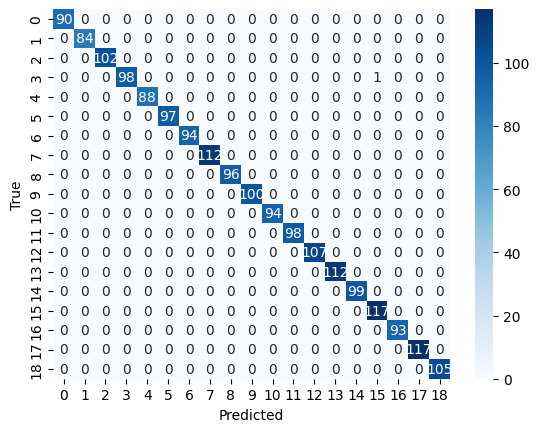

In [ ]:

from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_confusion_matrix(model, val_loader, device):


    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(predicted.cpu().numpy().tolist())

    cm = confusion_matrix(y_true, y_pred)
    return cm
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
# Example usage after training the model
cm = calculate_confusion_matrix(model, val_loader, device)
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn or matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:

from sklearn.metrics import classification_report



def calculate_classwise_accuracy(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(predicted.cpu().numpy().tolist())

    report = classification_report(y_true, y_pred, target_names=dataset.classes, output_dict=True)
    return report


class_wise_accuracy = calculate_classwise_accuracy(model, val_loader, device)

for class_name, metrics in class_wise_accuracy.items():
  if class_name in dataset.classes:
    print(f"Class: {class_name}, Accuracy: {metrics['precision']}")

Class: clamps_augmented_augmented, Accuracy: 1.0
Class: corals_augmented_augmented, Accuracy: 1.0
Class: dolphin_augmented_augmented, Accuracy: 1.0
Class: eel_augmented_augmented, Accuracy: 1.0
Class: fish_augmented_augmented, Accuracy: 1.0
Class: jellyfish_augmented_augmented, Accuracy: 1.0
Class: lobster_augmented_augmented, Accuracy: 1.0
Class: nudibranchs_augmented_augmented, Accuracy: 1.0
Class: octopus_augmented_augmented, Accuracy: 1.0
Class: puufer_augmented_augmented, Accuracy: 1.0
Class: sea rays_augmented_augmented, Accuracy: 1.0
Class: sea urchins_augmented_augmented, Accuracy: 1.0
Class: seahorse_augmented_augmented, Accuracy: 1.0
Class: seal_augmented_augmented, Accuracy: 1.0
Class: shark_augmented_augmented, Accuracy: 1.0
Class: squid_augmented_augmented, Accuracy: 0.9915254237288136
Class: starfish_augmented_augmented, Accuracy: 1.0
Class: turtle_augmented_augmented, Accuracy: 1.0
Class: whale_augmented_augmented, Accuracy: 1.0
